
**Name**: *Anas Shahid*

**Student ID**: *15160*


Assignment 1: Text Analysis and Entity Resolution
===

## Overview

Entity resolution is a common, yet difficult problem in data cleaning and integration.
In this assignment, we will use powerful and scalable text analysis techniques to perform entity resolution across two data sets of commercial products.

NOTE: Please read the "homework policy" section on the course website.

NOTE: You must submit a printed copy of a run ipython notebook at class on the due date. Also, a softcopy must be submitted, submission details for the softcopy submission will be provided in class.

### Entity Resolution

Entity resolution, also known as record deduplication, is the process of identifying rows in one or more data sets that refer to the same real world entity.
Take an example.
You're on ebay looking for a [hip data science accessory][sliderulewiki], but you're on a budget, so you decide to scrape the [ebay listings][ebay] for a few days to get a feel for the market.
Unfortunately, the listings are confusing and you don't know how to aggregate them.
Entity resolution to the rescue!
You find an [authoritative database][sliderules] and map all the ebay listings to it.
Now you can comparison shop, get that sweet Keuffel and Esser for way cheap, and impress all the data hipsters.

But finding matching records is a hard problem in general.
A major reason is that the criteria for identifying duplicates are often vague and impossible to encode in rules.
In addition, from a purely computational perspective, the problem is quadratic in the size of its inputs: naively, all pairs of records need to be compared to find all the duplicates.
In this assignment, we will begin to address both these challenges.

[sliderulewiki]: http://en.wikipedia.org/wiki/Slide_rule "Only 2X faster than Hadoop"

[sliderules]: http://www.sliderule.ca/ "Artisanal Data Technology"

[ebay]: http://www.ebay.com/sch/i.html?_odkw=keuffel+esser+slide+rule&_osacat=0&_trksid=p2045573.m570.l1313.TR0.TRC0.Xslide+rule&_nkw=slide+rule&_sacat=0&_from=R40 "Impress your colleagues"


### Application

Your assignment is to perform entity resolution over two web-scraped data sets of commercial product listings, one from Amazon, and one from Google.
The goal is to build a unified database of all products listed on the Internet: a one-stop-shop for all your shopping needs.  (Elevator pitch: *it's like **Kayak.com** for **e-commerce**!*)

The web has made unprecedented amounts of data available publicly, but scraped data frequently needs to be de-duplicated.
These data sets are typical examples of what you can collect with some simple scripting.
The data is not especially large (just a few thousand records), but even so, you will find that entity resolution is a major challenge (top results with this data are ~50% success rate).
Don't get discouraged; the goal is to get acquainted with techniques to tackle the problem, and apply them to a representative example.


### Files

Data files for this assignment can be found at hw1/hw1data.tar.gz in the zip file you downloaded for this assignment.

The zip file includes the following files:

* **Google.csv**, the Google Products data set 
* **Amazon.csv**, the Amazon data set
* **Google_small.csv**, 200 records sampled from the Google data
* **Amazon_small.csv**, 200 records sampled from the Amazon data
* **Amazon_Google_perfectMapping.csv**, the "gold standard" mapping
* **stopwords.txt**, a list of common English words

Besides the complete data files, there are "sample" data files for each data set.
Use these for **Part 1**.
In addition, there is a "gold standard" file that contains all of the true mappings between entities in the two data sets.
Every row in the gold standard file has a pair of record IDs (one Google, one Amazon) that belong to two record that describe the same thing in the real world.
We will use the gold standard to evaluate our algorithms.

### Deliverables


Complete all the exercises below and turn in a write up in the form of an IPython notebook, that is, **an .ipynb file**.
The write up should include your code, answers to exercise questions, and plots of results.

Use this notebook and fill in answers inline.
In this notebook, we provide code templates for many of the exercises. Please use these templates.
They are intended to help with code re-use, since the exercises build on each other.
Remember to include answers to questions that ask for natural language responses, i.e., in English, not code!

### Guidelines

#### Code

This assignment can be done with basic python and matplotlib.
Feel free to use PANDAs, too, which you may find well suited to several exercises.
As for other libraries, please check with course staff whether they're allowed.
In general, we want you to use whatever is comfortable, except for libraries (e.g., NLTK) that include functionality covered in the assignment.

You're not required to do your coding in IPython, so feel free to use your favorite editor or IDE.
But when you're done, remember to put your code into a notebook for your write up.

#### Collaboration

This assignment is to be done individually.  Everyone should be getting a hands on experience in this course.  You are free to discuss course material with fellow students, and we encourage you to use Internet resources to aid your understanding, but the work you turn in, including all code and answers, must be your own work.

## Part 0: Preliminaries

### Exercise 0

Download the data and unzip it.
Read each file in from the file system, and store them as lists of lines.

For each of the data files ("Google.csv", "Amazon.csv", and the samples), we want to parse the IDs out of each record.
The IDs are the first column of the file (they are URLs for Google, and alphanumeric strings for Amazon).
Omitting the headers, load these data files into *dictionaries mapping ID to a string containing the rest of the record*.


In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
def CsvToDict(csvFiles):
    '''This method Gets a CSV file and return a dictionary with id being the key and other columns as values'''
    for item in csvFiles:
        df = pd.read_csv(os.path.join(DATA_PATH,item),sep=',')
        file_dict = df.set_index('id').to_dict()
        yield file_dict

In [3]:
BASE_PATH = os.getcwd()     #os.path.dirname(os.path.abspath(__file__)) 
DATA_PATH = os.path.join(BASE_PATH,'hw1data','data') # Make this the /path/to/the/data
CSV_FILES = ['Amazon.csv','Google.csv']
SMALL_DATASET_CSV=['Amazon_small.csv','Google_small.csv']

# TODO Load data files here...
csv_list = list(CsvToDict(CSV_FILES))

## Part 1: ER as Text Similarity

A simple approach to entity resolution is to treat all records as strings and compute their similarity with a string distance function.
In this section, we will build some components for bag-of-words text-analysis, and use them to compute record similarity.

### 1.1 Bags of Words

Bag-of-words is a conceptually simple yet powerful approach to text analysis.
The idea is to treat strings, a.k.a. **documents**, as *unordered collections* of words, or **tokens**, i.e., as bags of words.

> **Note on terminology**: "token" is more general than what we ordinarily mean by "word" and includes things like numbers, acronyms, and other exotica like word-roots and fixed-length character strings.
> Bag of words techniques all apply to any sort of token, so when we say "bag-of-words" we really mean "bag-of-tokens," strictly speaking.

Tokens become the atomic unit of text comparison.
If we want to compare two documents, we count how many tokens they share in common.
If we want to search for documents with keyword queries (this is what Google does), then we turn the keywords into tokens and find documents that contain them.

The power of this approach is that it makes string comparisons insensitive to small differences that probably do not affect meaning much, for example, punctuation and word order.



#### Exercise 1

**a**. Implement the function `simple_tokenize(string)` that takes a string and returns a list of tokens in the string.
`simple_tokenize` should split strings using the provided regular expression.
Since we want to make token-matching case insensitive, make sure all tokens are lower-case.
Give an interpretation, in natural language, of what the regular expression, `split_regex`, matches.

In [4]:
import re
quickbrownfox = "A Quick brown Fox jumps over the Lazy Dog"
split_regex = r'\W+'

# TODO Implement this
def simple_tokenize(string):
    lowercase_string = string.lower()
    return re.split(split_regex,lowercase_string)

print simple_tokenize(quickbrownfox) # Should give ['a', 'quick', 'brown', ... ]

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


> The split_regex is being used to split the string over the specified expression. The \W matches with characters that are not alpha-numeric and '+' sign is for 1 or more occurence of the preceding characters. So the string splits on one or more occurences of non alpha-numeric characters like whitespace.

**b**. *Stopwords* are common words that do not contribute much to the content or meaning of a document (e.g., "the", "a", "is", "to", etc.).
Stopwords add noise to bag-of-words comparisons, so the are usually excluded.
Using the included file "stopwords.txt", implement `tokenize`, an improved tokenizer that does not emit stopwords.


In [5]:
file = open(os.path.join(DATA_PATH,'stopwords.txt'))
stopwords = file.read().splitlines()
file.close()

# TODO Implement this
def Tokenize(string):
    simple_tokens = simple_tokenize(string)
    tokens_list=[token for token in simple_tokens if token not in stopwords]
    return tokens_list

print Tokenize(quickbrownfox) # Should give ['quick', 'brown', ... ]

['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']


In [6]:
#Helper Methods
def FilterInvalidValues(tokenValue):
    '''This method Filters the invalid string and returns empty string if None is found'''
    if isinstance(tokenValue,str):
        return tokenValue
    else:
        try:
            return str(tokenValue)
        except:
            return ''
        
def ListToTokens(record): 
    '''This method returns the tokens from the CSV files that is read above.'''
    columns = ['description','manufacturer','title','name'] # we are only considering tokens in these columns
    tokens_dict = dict()
    for col in columns:
        if not record.has_key(col):
            break
        dictionary = record[col]
        for k,v in dictionary.items(): #use iteritems() for python 2
            if tokens_dict.has_key(k):
                tokens_dict[k].extend(Tokenize(FilterInvalidValues(v)))
            else:
                tokens_dict[k]=Tokenize(FilterInvalidValues(v))

    return tokens_dict

In [7]:
#More Helper Methods
def CountTokens(dictionary):
    sum = 0
    for v in dictionary.itervalues():
        sum+=len(v) 
    return sum

def get_max_length_record(x):
    number_of_tokens=[len(n) for n in x.values()]
    return [k for k in x.keys() if len(x.get(k))==max(number_of_tokens)]

**c**. Now let's tokenize the two small data sets.
For each one build a dictionary of tokens, i.e., a dictionary where the record IDs are the keys, and the output of `tokenize` is the values.
How many tokens, total, are there in the two data sets?
Which Amazon record has the biggest number of tokens?

In [8]:
# TODO Compute these (dict() or DataFrame OK)
amazon_rec2tok=ListToTokens(csv_list[0])
google_rec2tok=ListToTokens(csv_list[1])

total_tokens = CountTokens(amazon_rec2tok) + CountTokens(google_rec2tok)
print 'There are %s tokens in the combined data sets' % total_tokens

biggest_record = get_max_length_record(amazon_rec2tok)
print 'The Amazon record with ID "%s" has the most tokens' % biggest_record

There are 277338 tokens in the combined data sets
The Amazon record with ID "['b000ndibqy']" has the most tokens


### 1.2 Weighted Bag-of-Words: TF-IDF

Bag-of-words comparisons are not very good when all tokens are treated the same: some tokens are more important than others.
Weights give us a way to specify which tokens to favor.
With weights, when we compare documents, instead of counting common tokens, we sum up the weights of common tokens.

A good heuristic for assigning weights is called "Term-Frequency/Inverse-Document-Frequency," or TF-IDF for short.

#### TF

TF rewards tokens that appear many times in the same document.
It is computed as the frequency of a token in a document, that is, if document `d` contains 100 tokens and token `t` appears in `d` 5 times, then the TF weight of `t` in `d` is `5/100 = 1/20`.
The intuition for TF is that if a word occurs often in a document, then it is more important to the meaning of the document.

#### IDF

IDF rewards tokens that are rare overall in a data set.
The intuition is that it is more significant if two documents share a rare word than a common one.
IDF weight for a token, *t*, in a set of documents, *U*, is computed as follows: 

* Let *N* be the total number of documents in *U*
* Find *n(t)*, the number of documents in *U* that contain *t*
* Then *IDF(t) = N/n(t)*.

Note that *n(t)/N* is the frequency of *t* in *U*, and *N/n* is the inverse frequency.

> **Note on terminology**: Sometimes token weights depend on the document the token belongs to, that is, the same token may have a different weight when it's found in different documents.  We call these weights `local` weights.  TF is an example of a local weight, because it depends on the length of the source.  On the other hand, some token weights only depend on the token, and are the same everywhere that token is found.  We call these weights `global`, and IDF is one such weight.

#### TF-IDF

Finally, to bring it all together, the total TF-IDF weight for a token in a document is the product of its TF and IDF weights.

#### Exercise 2

**a**. Implement `tf(tokens)` that takes a list of tokens belonging to a single document and returns a dictionary mapping tokens to TF weights.


In [9]:
# TODO Implement this
def tf(tokens):
    total_tokens=len(tokens)
    token_tf=dict()
    for tok in tokens:
        token_tf[tok]=float(tokens.count(tok))/total_tokens
    return token_tf


print tf(Tokenize(quickbrownfox)) # Should give { 'quick': 0.1666 ... }

{'brown': 0.16666666666666666, 'lazy': 0.16666666666666666, 'jumps': 0.16666666666666666, 'fox': 0.16666666666666666, 'dog': 0.16666666666666666, 'quick': 0.16666666666666666}


**b**. Implement `find_idfs` that assigns an IDF weight to every unique token in a collection of data called `corpus`.  You may structure `corpus` however you want, but `find_idfs` should return a dictionary mapping tokens to weights.  Use `find_idfs` to compute IDF weights for all tokens in the combined small data sets.  How many unique tokens are there?

In [10]:
#Helper Method
def get_unique_tokens(list):
    '''Takes a list of dictionary and returns the unique tokens'''
    tempList=[];
    for param in list:
        for values in param.itervalues(): #This is a dictionary
            for item in values:
                tempList.append(item)
    return set(tempList)

In [11]:
# TODO Implement this
def find_idfs(corpus):
    '''Takes a list of dictionary,returns the idf weights of the unique tokens.'''
    idf_values={}
    all_token_set=get_unique_tokens(corpus)
    valueList=[v for param in corpus for v in param.values()]
    for tkn in all_token_set:
        list_containing_token=map(lambda doc:tkn in doc,valueList)
        idf_values[tkn]=len(valueList)/sum(list_containing_token)
    return idf_values

small_data_list= list(CsvToDict(SMALL_DATASET_CSV)) #Read the small data files
all_small_tokens=map(lambda x:ListToTokens(x),small_data_list)

idfs_small = find_idfs(all_small_tokens) #use find_idfs here

unique_tokens=len(get_unique_tokens(all_small_tokens)) 
print "There are %s unique tokens in the small data sets." % unique_tokens

There are 4643 unique tokens in the small data sets.


**c**. What are the 10 tokens with the smallest IDF in the combined small data set?  Do you think they are useful for entity resolution?  Why or why not?

In [12]:
smallest_tokens_tuple =list((sorted(idfs_small.iteritems(),key=lambda (k,v): v)[:10]))
small_idf_tokens = [k for (k,v) in smallest_tokens_tuple]
print small_idf_tokens

['', 'nan', 'software', 'new', 'features', 'easy', 'use', 'complete', 'cd', 'system']


> The tokens with the smallest IDF represent that they occur in most documents (since the sum of count is in denominator). This can be used for entity resolution as we can determine which tokens are present in most documents

**d**. Plot a histogram of IDF values.  Be sure to use appropriate scaling and bucketing for the data.  What conclusions can you draw from the distribution of weights?

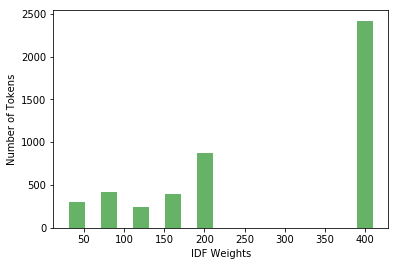

In [13]:
import pylab as plt
%matplotlib inline

# TODO Make a plot. HINT: You can use pylab.hist

plt.hist(np.array(idfs_small.values()),color='g',alpha=0.6,rwidth=0.5,align='right')
plt.xlabel("IDF Weights")
plt.ylabel("Number of Tokens")
plt.show()

> The result represents that there are a large set of tokens that are not repeated and has max idf values. However there are tokens that are repeated which are represented at by the smaller left bars.

**e**. Use `tf` to implement `tfidf(tokens, idfs)` that takes a list of tokens from a document and a dictionary of idf weights and returns a dictionary mapping tokens to total TF-IDF weight.  Use `tfidf` to compute the weights of Amazon product record 'b000hkgj8k'.

In [14]:
# TODO Implement this
def tfidf(tokens, idfs):
    tfidf={}
    tf_values_dict=tf(tokens)
    for k,v in tf_values_dict.iteritems():
        tfidf[k]=v*idfs[k]
    return tfidf

rec_b000hkgj8k_weights =tfidf(all_small_tokens[0]['b000hkgj8k'],idfs_small)
print "Amazon record 'b000hkgj8k' has tokens and weights:\n%s" % rec_b000hkgj8k_weights

Amazon record 'b000hkgj8k' has tokens and weights:
{'autocad': 33.33333333333333, 'autodesk': 8.333333333333332, 'courseware': 66.66666666666666, 'psg': 33.33333333333333, '2007': 3.833333333333333, 'customizing': 16.666666666666664, 'interface': 3.0}



### 1.3 Cosine Similarity

Now we are ready to do text comparisons in a formal way.
The metric of string distance we will use is called **cosine similarity**.
We will treat each document as a vector in some high dimensional space.
Then, to compare two documents we compute the cosine of the angle between their two document vectors.
This is easier than it sounds.

The first question to answer is how do we represent documents as vectors?
The answer is familiar: bag-of-words!
We treat each unique token as a dimension, and treat token weights as magnitudes in their respective token dimensions.
For example, suppose we use simple counts as weights, and we want to interpret the string "Hello, world!  Goodbye, world!" as a vector.
Then in the "hello" and "goodbye" dimensions the vector has value 1, in the "world" dimension it has value 2, and it is zero in all other dimensions.

Next question is: given two vectors how do we find the cosine of the angle between them?
Recall the formula for the dot product of two vectors:

$$a \cdot b = \| a \| \| b \| \cos \theta$$

Here $a \cdot b = \sum_{i=1}^n a_i b_i$ is the ordinary dot product of two vectors, and $\|a\| = \sqrt{ \sum_{i=1}^n a_i^2 }$ is the norm of $a$.

We can rearrange terms and solve for the cosine to find it is simply the normalized dot product of the vectors.
With our vector model, the dot product and norm computations are simple functions of the bag-of-words document representations, so we now have a formal way to compute similarity:

$$similarity = \cos \theta = \frac{a \cdot b}{\|a\| \|b\|} = \frac{\sum_{i=1}^n a_i b_i}{\sqrt{\sum_{i=1}^n a_i^2} \sqrt{\sum_{i=1}^n b_i^2}}$$

Setting aside the algebra, the geometric interpretation is more intuitive.
The angle between two document vectors is small if they share many tokens in common, because they are pointing in roughly the same direction.
Then, the cosine of the angle will be large.
Otherwise, if the angle is large (and they have few words in common), the cosine is small.
So the cosine scales proportionally with our intuitive sense of similarity.


#### Exercise 3

**a**. Implement `cosine_similarity(string1, string2, idfs)` that takes two strings and computes their cosine similarity in the context of some global IDF weights.
Use `tokenize`, `tfidf`, and the IDF weights from exercise **2b** for extracting tokens and assigning them weights.


In [15]:
import math

# Optional utility
def dotprod(a, b):
    return sum(a[key]*b.get(key, 0) for key in a)

def norm(vector):
    sum=0
    for x in vector.itervalues():
        sum+=x**2
    return math.sqrt(sum)

# Optional freebie
def cossim(a, b):
    return dotprod(a, b) / norm(a) / norm(b)

test_vec1 = {'foo': 2, 'bar': 3, 'baz': 5 }
test_vec2 = {'foo': 1, 'bar': 0, 'baz': 20 }
print dotprod(test_vec1, test_vec2), norm(test_vec1) # Should be 102 6.16441400297

# TODO Implement this
def cosine_similarity(string1, string2, idfs):
    string1_weights=tfidf(Tokenize(string1),idfs)
    string2_weights=tfidf(Tokenize(string2),idfs)
    return cossim(string1_weights,string2_weights)

print cosine_similarity("Adobe Photoshop",
                        "Adobe Illustrator", 
                        idfs_small) # Should be 0.0577243382163

102 6.16441400297
0.0885223532842


**b**. Now we can finally do some entity resolution!
For every product record in the small Google data set, use `cosine_similarity` to compute its similarity to every record in the small Amazon set.  Build a dictionary mapping `(Amazon Id, Google Id)` tuples to similarity scores between 0 and 1.
What is the similarity between Amazon record 'b000o24l3q' and Google record `http://www.google.com/base/feeds/snippets/17242822440574356561`.

In [16]:
#Helper Methods

def cosine_similarity_from_tokens(stringTokens1,stringTokens2,idfs):
    '''This method return cosine similarity between 2 tokenized strings'''
    string1_weights = tfidf(stringTokens1, idfs)
    string2_weights = tfidf(stringTokens2, idfs)
    return cossim(string1_weights, string2_weights)

def get_similarity_dict(dict1,dict2,idfs):
    '''Gets the 2 dictionaries and returns their cosine similarity'''
    similarity_dict=dict()
    for (key1,value1) in dict1.iteritems():
        for (key2,value2) in dict2.iteritems():
            similarity_dict[(key1,key2)]=cosine_similarity_from_tokens(value1,value2,idfs)
    return similarity_dict

In [17]:
# TODO Compute similarities
similarities=get_similarity_dict(all_small_tokens[0],all_small_tokens[1],idfs_small)

print 'Requested similarity is %s.' % similarities[('b000o24l3q',
  'http://www.google.com/base/feeds/snippets/17242822440574356561')]

Requested similarity is 0.000263957537208.


**c**.  Use the "gold standard" data (loaded from the included file) to answer the following questions.  How many true duplicate pairs are there in the small data set?  What is the average similarity score for true duplicates?  What about for non-duplicates?  Based on this, is cosine similarity doing a good job, qualitatively speaking, of identifying duplicates?  Why or why not?

In [18]:
def check_duplicates(source,mapping_tuple):
    matched_list={}
    for item in mapping_tuple:
        if source.has_key(item):
            matched_list[item]=source[item]
    return matched_list

def filter_duplicates(source,mapping_tuple):
    unmatched_list={}
    for k,v in source.items():
        if k not in mapping_tuple:
            unmatched_list[k]=v
    return unmatched_list

In [19]:
gold_standard = pd.read_csv(os.path.join(DATA_PATH,'Amazon_Google_perfectMapping.csv'),sep=',') # Load this if not already loaded
gold_standard_list=[tuple(x) for x in gold_standard.values]

small_dataset_dups= check_duplicates(similarities,gold_standard_list)
small_dataset_nondups=filter_duplicates(similarities,gold_standard_list)

true_dups = len(small_dataset_dups.keys()) # Fix me

avg_sim_dups = np.array(list(small_dataset_dups.values())).mean()
avg_sim_non = np.array(list(small_dataset_nondups.values())).mean()

print "There are %s true duplicates." % true_dups
print "The average similarity of true duplicates is %s." % avg_sim_dups
print "And for non duplicates, it is %s." % avg_sim_non

There are 146 true duplicates.
The average similarity of true duplicates is 0.202622780721.
And for non duplicates, it is 0.00116910480319.


> Cosine similarity does a good job for entity resolution and is one of the most commonly used techniques for string matching. However we need to determine the threshold of the matching strings.

## Part 2: Scalable ER

In the previous section we built a text similarity function and used it for small scale entity resolution.  Our implementation is limited by its quadratic run time complexity, and is not practical for even modestly sized data sets.  In this section we will implement a more scalable algorithm and use it to do entity resolution on the full data set.

### Inverted Indices

To improve our ER algorithm from **Part 1**, we should begin by analyzing its running time.
In particular, the algorithm above is quadratic in two ways.
First, we did a lot of redundant computation of tokens and weights, since each record was reprocessed every time it was compared.
Second, we made qudratically many token comparisons between records.

The first source of quadratic overhead can be eliminated with precomputation and look-up tables, but the second source is a little more tricky.
In the worst case, every token in every record in one data set exists in every record in the other data set, and therefore every token makes a nonzero contribution to the cosine similarity.
In this case, token comparison is unavoidably quadratic.

But in reality most records have nothing (or very little) in common.
Moreover, it is typical for a record in one data set to have at most one duplicate record in the other data set (this is the case assuming each data set has been de-duplicated against itself).
In this case, the output is linear in the size of the input and we can hope to achieve linear running time.

An **inverted index** is a data structure that will allow us to avoid making quadratically many token comparisons.  It maps each token in the data set to the list of documents that contain the token.  So, instead of comparing, record by record, each token to every other token to see if they match, we will use inverted indices to *look up* records that match on a particular token.

> **Note on terminology**: In text search, a *forward* index maps documents in a data set to the tokens they contain.  An *inverted* index supports the inverse mapping.


#### Exercise 4

> **Note**: For this section, use the complete Google and Amazon data sets, not the samples

> **Pandas note**: If you use DataFrames for the mapping tables, make sure you index them correctly for efficient key look ups

**a**. To address the overhead of recomputing tokens and token-weights, build a dictionary for each data set that maps record IDs to TF-IDF weighted token vectors (the vectors themselves should be dictionaries).  You will need to re-use code from above to recompute IDF weights for the complete combined data set.

In [20]:
# TODO Redo tokenization for full data set
amazon_rec2tok=ListToTokens(csv_list[0])
google_rec2tok=ListToTokens(csv_list[1])

# TODO Recompute IDFs for full data set
idfs = find_idfs([amazon_rec2tok,google_rec2tok])

In [21]:
def get_id_weights(dict1,thisidfs):
    id_weights={}
    for (key1,value1) in dict1.iteritems():
        id_weights[key1]=tfidf(value1, thisidfs)
    return id_weights

def get_id_norms(dict):
    id_norms={}
    for (key,value) in dict.iteritems():
        id_norms[key]=norm(value)
    return id_norms

In [22]:
# TODO Pre-compute TF-IDF weights.  Build mappings from record ID weight vector.
google_weights = get_id_weights(google_rec2tok, idfs)
amazon_weights = get_id_weights(amazon_rec2tok, idfs)

# TODO Pre-compute norms.  Build mappings from record ID to norm of the weight vector.
google_norms = get_id_norms(google_weights)
amazon_norms = get_id_norms(amazon_weights)

**b**. Build inverted indices of both data sources.

In [28]:
# TODO Implement this. Should return a mapping from token to list-of-record-IDs
def invert_index(forward_index):
    # newdict={}
    uniq_tokens=list(get_unique_tokens([forward_index,]))
    newdict={word: list(set(key for key,wrds in forward_index.items() if word in wrds)) for word in uniq_tokens }
    return newdict

# TODO Pre-compute inverted indices
amazon_inv = invert_index(amazon_weights)
google_inv = invert_index(google_weights)

**c**. We are now in position to efficiently perform ER on the full data sets.
Implement the following algorithm to build a dictionary that maps a pair of records (as a tuple) to a list of tokens they share in common:
Iterate over tokens of one data set, and for each token, if the token appears in the other data set, use the inverted indices to find all pairs of records (one from either set) that contain the token.  Add these pairs to the output.

In [31]:
from itertools import *
def get_token_combinations(all_tokens,inv_dict_1,inv_dict_2):
    combination_dict={}
    for token in all_tokens:
        if inv_dict_1.has_key(token) and inv_dict_2.has_key(token):
            combinations=product(inv_dict_1[token],inv_dict_2[token])
            for combo in combinations:
                if combination_dict.has_key(combo):
                    combination_dict[combo].append(token)
                else:
                    combination_dict[combo]=[token]
    return combination_dict

In [32]:

unique_tokens=get_unique_tokens([amazon_rec2tok,google_rec2tok])
# TODO Implement algorithm to compute this:
common_tokens = get_token_combinations(unique_tokens,amazon_inv,google_inv)

print len(common_tokens)

3325883


**d**. Use the data structures from parts **a** and **c** to build a dictionary to map record pairs to cosine similarity scores.

In [37]:
# TODO Implement this. Should take two record IDs and a list of common
# tokens and return the cosine similarity of the two records.
# Use results from part *a* for fast look ups.
def fast_cosine_similarity(a_rec, g_rec):
    tokens=common_tokens[(a_rec,g_rec)]
    dotSum=sum([amazon_weights[a_rec][tok]*google_weights[g_rec][tok] for tok in tokens])
    cos_sim=dotSum/(amazon_norms[a_rec]*google_norms[g_rec])
    return cos_sim

def get_sim_dict():
    sim_dict={}
    for key,value in common_tokens.items():
        sim_dict[key]=fast_cosine_similarity(key[0],key[1])
    return sim_dict
# TODO Compute similarities (use fast_cosine_similarity)
sims =get_sim_dict()
print sims[('b000o24l3q','http://www.google.com/base/feeds/snippets/17242822440574356561')]

0.000278211358013



### Analysis

Now we have an authoritative list of record-pair similarities, but we need a way to use those similarities to decide if two records are duplicates or not.
The simplest approach is to pick a **threshold**.
Pairs whose similarity is above the threshold are declared duplicates, and pairs below the threshold are declared distinct.

To decide where to set the threshold we need to understand what kind of errors result at different levels.
If we set the threshold too low, we get more **false positives**, that is, record-pairs we say are duplicates that in reality are not.
If we set the threshold too high, we get more **false negatives**, that is, record-pairs that really are duplicates but that we miss.

ER algorithms are evaluated by the common metrics of information retrieval and search called **precision** and **recall**.
Precision asks of all the record-pairs marked duplicates, what fraction are true duplicates?
Recall asks of all the true duplicates in the data, what fraction did we successfully find?
As with false positives and false negatives, there is a trade-off between precision and recall.
A third metric, called **F-measure**, takes the harmonic mean of precision and recall to measure overall goodness in a single value.:

$$Fmeasure = 2 \frac{precision * recall}{precision + recall}$$


#### Exercise 5

> **Note**: For this exercise, use the "gold standard" mapping from the included file to look up true duplicates, and the results of exercise 4.

**a**. Implement functions to count true-positives (true duplicates above the threshold), and false-positives and -negatives.  HINT: To make your functions efficient, you should bin your counts by similarity range.

In [ ]:
# Look up all similarity scores for true duplicates
true_dup_sims = [] # TODO Build this

# TODO Just compute true_dup_sim above
def truepos(threshold):
    return len(true_dup_sims) - falseneg(threshold)

# Pre-bin counts of false positives by threshold range
nthresholds = 100
def bin(similarity):
    return int(similarity * nthresholds)

fp_counts = {} # TODO Build this.  Should map bin number to count of false-positives

# TODO Implement this
def falsepos(threshold):
    pass

# TODO Implement this
def falseneg(threshold):
    pass

**b**. What is the relationship between false-positives and -negatives (and true-positives and -negatives) on the one hand and precision and recall on the other?
Use the functions from part **a** to implement functions to compute precision, recall, F-measure as a function of threshold value.

In [ ]:
# TODO Implement this (returns a float)
def precision(threshold):
    pass

# TODO Implement this (returns a float)
def recall(threshold):
    pass

# TODO Implement this (returns a float)
def fmeasure(threshold):
    pass

**c**. Make line plots of precision, recall, and F-measure as a function of threshold value, for thresholds between 0.0 and 1.0.  You can change `nthresholds` (above in part **a**) to change threshold values to plot.

In [ ]:
# For the x-axis
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]

# TODO Make a plot.  HINT: Use pylab.plot().  Don't forget labels.

**d**. Using the plot, pick the optimal threshold value and argue for why it is optimal.
If false-positives are considered much worse than false-negatives, how does that change your answer?


> TODO Answer questions

**e**.  State-of-the-art tools can get an F-measure of about 60% on this data set.
In this assignment we expect to get an F-measure closer to 40%.
Look at some examples of errors (both false-positives and -negatives) and think about what went wrong.
What are some ways we might improve our simple classifier?
Back up your ideas with examples as much as possible.

> TODO Answer questions